# Train GPT-2

This notebook is a summary of Andrej Karpathy's [Let's reproduce GPT-2 (124M)](https://youtu.be/l8pRSuU81PU?si=R5EVkxD1oocOQEI-) lecture as part of the Neural Networks: Zero to Hero series.

The GPT-2 model is publicly released, but the GPT-2 paper does not go too much into the training details. On the other hand, the GPT-3 paper is a lot more detailed, but the model is not publicly released. Therefore, we try to replicate as much of the GPT training as possible by combining techniques from the GPT-2 and GPT-3 papers (both models are very similar architecturally). In particular, we will try to replicate the 124M parameter model.

## GPT-2 Architecture

We will use the same layers/parameters as in HuggingFace's GPT-2 implementation (we are not following the OpenAI code because it uses TensorFlow).

In [1]:
from transformers import GPT2LMHeadModel;

# let's inspect the HF GPT model
model_hf = GPT2LMHeadModel.from_pretrained("gpt2") # 124M version
sd_hf = model_hf.state_dict()

for k,v in sd_hf.items():
    print(k, v.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

Note there are 50257 tokens, embedding size is 768 (`wte` is embedding layer), context length is 1024 (`wpe` is positional encoding layer)

In original "Attention is All You Need" paper, the positional embeddings are initialized and fixed to sinusoidal functions, but the GPT paper treats them as trainable parameters, which works just as well.

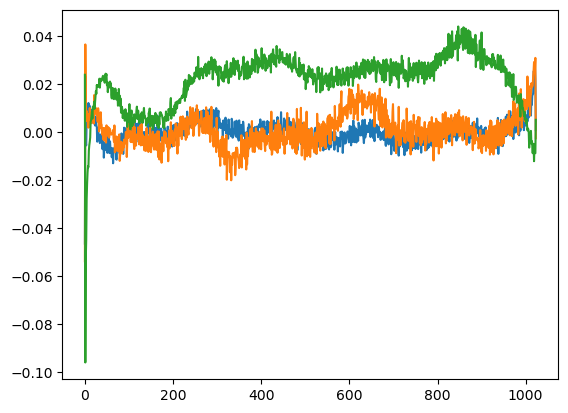

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(sd_hf["transformer.wpe.weight"][:, 150])
plt.plot(sd_hf["transformer.wpe.weight"][:, 200])
plt.plot(sd_hf["transformer.wpe.weight"][:, 250])

### Changes GPT 2 made to the transformer architecture
1. Decoder-only
2. Reshuffling of the LayerNorms so that it is applied before the MLP/attention block
3. Additional LayerNorm after final self-attention block (before model head)

In our attention `Block`, we have an attention layer followed by a MLP layer. One perspective on this architecture is that attention is a reduce operation that allows tokens to talk to each other, and the MLP is a map operation in which tokens are processed independently of one another. So the stacked up blocks is similar to a repeated application of MapReduce, each application refining the representation of the data.

### GELU activation function
- Similar to RELU but doesn't have a flat region near 0
- There is an approximate version, which was used in GPT-2, due to performance reasons. Nowadays, the exact computation is a lot more optimized, so we should prefer it over the approximate version.

### Weight-Tying Scheme

In the following code cell, we can see that the Embedding layer (token -> embedding vector at the start of the model) and the model head (embedding -> token classification) are pointing to the identical tensor. This is due to a weight tying scheme implemented in the Attention is All You Need paper, and the intuition behind it is as follows:
- Embedding is used to upscale tokens to embeddings
- Model head takes an embedding to a token
- Both layers have a similar property: in the embedding layer, we want tokens with similar semantic meaning to map to similar embeddings; in the model head, we also want similar embeddings to have similar tokens (and have similar probabilities)

Reusing the same matrix for these two layers yields better results while significantly reducing the model size.

In [15]:
sd_hf["transformer.wte.weight"].data_ptr() == sd_hf["lm_head.weight"].data_ptr()

True

### Controlling variance growth in residual streams

The following cells demonstrate how the variance/standard deviation can grow inside residual streams following repeated addition. As discussed in previous lectures, high variance activations can cause softmax to create peaky vectors, which in turn will cause the model to be confidently wrong and slow down training. We can fight this by normalizing the values using a multiplicative factor of $\frac{1}{\sqrt{n}}$ where $n$ is the number of additions.

In the training code, this is implemented using the `NANOGPT_SCALE_INIT` flag.

In [17]:
# standard deviation grows inside the residual stream if we add multiple times
x = torch.zeros(768)
n = 100
for i in range(n):
    x += torch.randn(768)

print(x.std())

tensor(10.2207)


In [18]:
# normalize by 1/sqrt(n) to control growth of activations
x = torch.zeros(768)
n = 100
for i in range(n):
    x += n ** -0.5 * torch.randn(768)

print(x.std())

tensor(1.0111)


## Training Notes/Optimizations

### Moving tensors around on devices.

When you call `.to(device)` on a `tensor` object directly, the movement does not happen in-place. Therefore, you need to re-assign the result.

However, if you call `.to(device)` on something like a `nn.Module` object, it will move all tensors onto the requested device internally.

### Timing iterations when working on CUDA

`torch.cuda.synchronize()`
-> when we perform operations on CUDA, the CPU is simply scheduling some jobs to be performed on the GPU, and moves on without the job necessarily completing. `torch.cuda.synchronize()` waits for all scheduled jobs to complete.

### Mixed precision

PyTorch uses `dtype=float32` by default for tensors, which, empirically, for deep learning is a lot more precision than we usually need.

Also, this helps reduce the size of each tensor, improving the memory bandwidth usage. Typically, the bottleneck in training neural nets is the memory bandwidth (the tensor cores are usually waiting for data to process).

Therefore, reducing the precision can significantly speed up operations.

In a transformer network, the number of computations is dominated by `Linear` layers (especially the final classification layer) so speeding up matrix multiplication is key. We can just set matrix multiplications to use different precisions using the following code:

`torch.set_float32_matmul_precision(precision)`
- `precision=highest`: use float32
- `precision=high`: use tf32
- `precision=medium`: use bfloat16

tf32 is a data type that is only available on the NVIDIA Ampere series. It uses a reduced mantissa to limit the precision, but uses up only 19 bits. Setting the matrix multiplication precision above does not require any additional code changes.

According to Andrej, tf32 is a nice sweet spot between efficiency and precision where we can get significant speedups for almost free (in terms of precision).

bf16 vs fp16 datatypes:
- both use 16 bits
- bf16 uses 8 bits for the exponent and 7 bits for the mantissa
- fp16 uses 5 bits for the exponent and 10 bits for the mantissa

bf16 can represent the same range of numbers as 32 bits, albeit with less precision. This means we do not have to handle values to prevent overflow (e.g. gradient scaling) as we should using fp16.

Note that bf16 is also only available on the NVIDIA Ampere series.

Using mixed precision
- Wrap forward pass and loss calculation in a context manager: `with torch.autocast(device, dtype=torch.bfloat16)`
- In these regions, CUDA ops run in a `dtype` chosen by autocast to improve performance while maintaining accuracy
- Do NOT wrap backward pass and optimization step in the context manager
- We can also use `torch.cuda.amp.GradScaler` to prevent graidents from flushing to zero (underflowing)

Recommended read: https://pytorch.org/tutorials/recipes/recipes/amp_recipe.html#automatic-mixed-precision

### torch.compile

Compiler for neural networks

Do `model = torch.compile(model)`

Really no good reason to *not* use it, possibly except when you are debugging and want to do only a few runs quickly

This is fast because
- It replaces the Python interpreter (slow code) from kicking in whenever possible
- By knowing exactly which operations will take place, we can optimize read/writes to memory (especially on GPUs where memory bandwidth is the bottleneck). For example, to perform `3 * (2 + x)`, we would normally retrieve `x` from memory (GPU HBM), add `2`, write back to memory, retrieve it again, multiply `3`, and then write it back; however, once compiled, the intermediate result lives on the GPU SRAM, i.e. directly on the GPU, and is only written back once we get the final result. This is known as **kernel fusion**.

### FlashAttention

Introduced by a paper from Stanford.

Faster way to compute attention using kernel fusion. This is not found by `torch.compile` because it requires an algorithmic rewrite. The algorithmic rewrite performs more FLOPs than the original version, but by being mindful of what data lives in what memory and optimizing the memory bandwidth, the computation is up to ~7.6x faster.

FlashAttention never materializes the attention score matrix (the (T,T) matrix for each batch/attention_head). This is done by using an online softmax calculation. (Details not introduced in this lecture)

Use `F.scaled_dot_product_attention()` for FlashAttention in PyTorch.

### Using nice numbers

Always use nice numbers (numbers that involve many powers of two)

Many operations are processed in chunks of powers of two. Need special case handling for "ugly" numbers that do not fit into those chunks.

So look for ugly numbers in neural net and make them nice by increasing it to the nearest number that has many factors of 2 in it. You would think that increasing the parameter count would increase the number of FLOPs and in turn the total time, but often the computation time is shorter using nice numbers.

One example of this in our training code is artificially increasing the vocab size to 50304 from 50257.

### Algorithmic changes to optimize training

Follow methodology introduced in GPT3 paper (GPT2 paper lacks details)

- Use Adam optimizer with `betas=(0.9, 0.95)` and `eps=1e-8`
- Gradient clipping to 1.0
    - Reason for doing this is that you could be unlucky with a batch and get a very large loss, which in turn gives a very large gradient. This could shock the model in terms of the optimization, so it is nice to upper bound the gradient.
    - `torch.nn.utils.clip_grad_norm_()` performs gradient clipping and returns the gradient norm, which is always nice to visualize (it should be going down as the parameters converge)
- Learning rate: Cosine decay with warmup
- Batch size scheduler (ramp up batch size as training progresses)
    - Intuition for this is that in earlier stages of training, the network picks up on very simple patterns that appear across all examples, so our approximation of the gradient with a small batch size is good.
    - We do not implement it here, as it complicates the computation
- Weight decay: adds a regularization term that is based on the magnitude of the parameters to the loss to avoid overfitting (use `weight_decay=0.1`)
    - Intuition behind this is that this forces the network to learn in a way that splits the work across parameters by preventing certain parameters from being very high
- Gradient accumulation
    - how to effectively use a larger batch size than what your GPU can handle
    - GPT paper uses 0.5M batches, but our GPU cannot handle batches of that size
    - only step/zero gradients once you accumulate enough examples for your desired batch size 
    - note we need to introduce a multiplicative regularizer for the loss because accumulation of the gradient corresponds to a SUM operation in the loss, whereas if we had used a single batch, all the losses would be reduced using a mean operation

### DistributedDataParallel

Concurrent computations across GPUs using PyTorch's `DistributedDataParallel`. All GPUs run a same script but on different parts of the data


How do we get each GPU to work in parallel?
-> In the simplest setting, when we wrap a model in `DDP` this causes the GPUs to sync after the backward pass. That is, after the backward pass completes, PyTorch computes and deposits the average of the gradients across all GPUs to each individual GPU (i.e. calls `dist.all_reduce`). So each GPU will end up with the same gradient for the optimizer step. Note that there is no single process that keeps track of the overall gradient and orchestrates the training.

DDP parameters:
- `world_size`: total # of processes running
- `ddp_rank`: a unique number in the range `[0, world_size - 1]` that is assigned to each GPU

To run a DDP-enabled script, use `torchrun` command from the commandline, e.g. `torchrun --standalone --nproc_per_node=8 train_gpt2.py`

### Training set

GPT used an unreleased dataset called WebText. OpenWebText is a project that aims to replicate that dataset publicly (by scraping all outbound links from Reddit with more than 3 karma).

The GPT-3 paper discusses the training dataset in more depth. Most of the trainign data comes from a dataset known as Common Crawl. Common Crawl is a very noisy dataset that includes a lot of garbage data (stock tickers, non-sensical text, etc.). Usually a filtered versions of Common Crawl is used and also in conjunction with other datasets as a data mixture.

We will train our model on FineWeb, which is a filtered version of Common Crawl, curated by HuggingFace. In particular, we will use the `sample-10BT` subset of FineWeb-Edu which only includes educational content from FineWeb (whether the content is education is judged by a LLM). The [FineWeb blog post](https://huggingface.co/spaces/HuggingFaceFW/blogpost-fineweb-v1) is a recommended read.

### HellaSwag Evaluation

HellaSwag is a popular dataset to evaluate language models. It provides first part of a sentence and asks the model to choose among four options that complete the sentence most naturally. The options are created in an adversarial manner which makes the task more difficult for language models.

HellaSwag is pretty much solved at this point by modern LLMs, but it is still popular because it has a smooth increase in accuracy and has early detection.

Because our model is so small, it does not understand the concept of multiple choice. Therefore, we need to frame the question natively in the next token prediction manner. We set up a batch of size 4 with the initial context shared among the examples and each option following the context for each example. Then the example with the highest average probability over each token in the option section is selected as the answer. 